In [1]:
!pip install -q -U bitsandbytes datasets pyarrow evaluate peft trl #transformers
!pip install -q -U git+https://github.com/huggingface/trl.git # For SFTTrainer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 34.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Install dependencies

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
# import kagglehub
# from kagglehub import KaggleDatasetAdapter

import os
from os import listdir
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
# from keras.utils.np_utils import to_categorical
# from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import evaluate
import glob
import PIL
from PIL import Image
import random

random.seed(420)

from datasets import Dataset, Image as HFImage, Features, ClassLabel, Value

from huggingface_hub import login
os.environ["HF_TOKEN"] = ""
login(token=os.environ["HF_TOKEN"])

!pip freeze | grep transformers

2025-12-21 09:25:44.477280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766309144.654266     101 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766309144.706165     101 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766309145.137528     101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766309145.137571     101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766309145.137574     101 computation_placer.cc:177] computation placer alr

sentence-transformers==5.1.1
transformers==4.57.1


## Get the path to images from dicom dataset

In [3]:
dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
roi_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path

full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
roi_mask_images = roi_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

full_mammogram_dict = dict()
cropped_dict = dict()
roi_mask_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[5]
    full_mammogram_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[5]
    cropped_dict[key] = dicom
for dicom in roi_mask_images:
    key = dicom.split("/")[5]
    roi_mask_dict[key] = dicom

next(iter((full_mammogram_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

## Load train and test data for masses from CSV

In [4]:
mass_train_data_all = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_train_data = mass_train_data_all[mass_train_data_all.pathology != "BENIGN_WITHOUT_CALLBACK"]
mass_train_data.columns = mass_train_data.columns.str.strip().str.replace(r'\s+', '_', regex=True)

mass_test_data_all = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
mass_test_data = mass_test_data_all[mass_test_data_all.pathology != "BENIGN_WITHOUT_CALLBACK"]
mass_test_data.columns = mass_test_data.columns.str.strip().str.replace(r'\s+', '_', regex=True)

print(f"Mass train data all pathologies: {len(mass_train_data_all)}")
print(f"Mass train data NO Callback: {len(mass_train_data)}")
print(f"Mass test data all pathologies: {len(mass_test_data_all)}")
print(f"Mass test data NO Callback: {len(mass_test_data)}")

Mass train data all pathologies: 1318
Mass train data NO Callback: 1214
Mass test data all pathologies: 378
Mass test data NO Callback: 341


## Fix image path in masses CSV to match the one in dicom

In [5]:
def fix_image_path_mass(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        # print(img[11])
        # print(img_name)
        if img_name in full_mammogram_dict:
            dataset.iloc[i, 11] = full_mammogram_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_dict:
            dataset.iloc[i, 12] = cropped_dict[img_name]
        
        img_name = img[13].split("/")[2]
        if img_name in roi_mask_dict:
            dataset.iloc[i, 13] = roi_mask_dict[img_name]

fix_image_path_mass(mass_train_data)
fix_image_path_mass(mass_test_data)

In [6]:
mass_train_data["pathology"].value_counts()
mass_test_data["pathology"].value_counts()
# mass_train_data["mass_shape"].value_counts()
# mass_train_data["mass_distribution"].value_counts()
# mass_train_data["assessment"].value_counts()
# mass_train_data["subtlety"].value_counts()


# #train
# masses_type_counts = mass_train_data["mass_shape"].value_counts()
# mask = (masses_type_counts/masses_type_counts.sum() * 100).lt(10)
# mass_train_data['mass_shape_aggr'] = np.where(mass_train_data['mass_shape'].isin(masses_type_counts[mask].index),'Other',mass_train_data['mass_shape'])

# mass_train_data["target_label"] = mass_train_data["pathology"]+'_'+mass_train_data["mass_shape_aggr"] 
# mass_train_data["target_label"].value_counts()

# #test
# masses_type_counts = mass_test_data["mass_shape"].value_counts()
# mask = (masses_type_counts/masses_type_counts.sum() * 100).lt(30)
# mass_test_data['mass_shape_aggr'] = np.where(mass_test_data['mass_shape'].isin(masses_type_counts[mask].index),'Other',mass_test_data['mass_shape'])

# mass_test_data["target_label"] = mass_test_data["pathology"]+'_'+mass_test_data["mass_shape_aggr"] 
# mass_test_data["target_label"].value_counts()

mass_train_data["assessment"].value_counts()

assessment
4    525
5    297
3    234
0    129
2     28
1      1
Name: count, dtype: int64

## Show and example

BENIGN
IRREGULAR


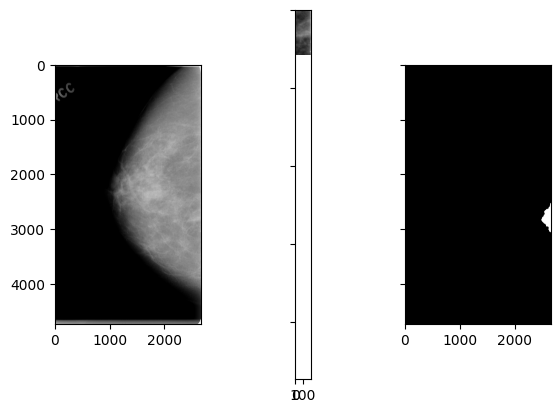

In [7]:
image_id = 1234
full = PIL.Image.open(mass_train_data["image_file_path"][image_id]).convert("L")

cropped = PIL.Image.open(mass_train_data["cropped_image_file_path"][image_id]).convert("L")

roi = PIL.Image.open(mass_train_data["ROI_mask_file_path"][image_id]).convert("L")

print(mass_train_data["pathology"][image_id])
print(mass_train_data["mass_shape"][image_id])
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(full, cmap='gray')
ax2.imshow(cropped, cmap='gray')
ax3.imshow(roi, cmap='gray')

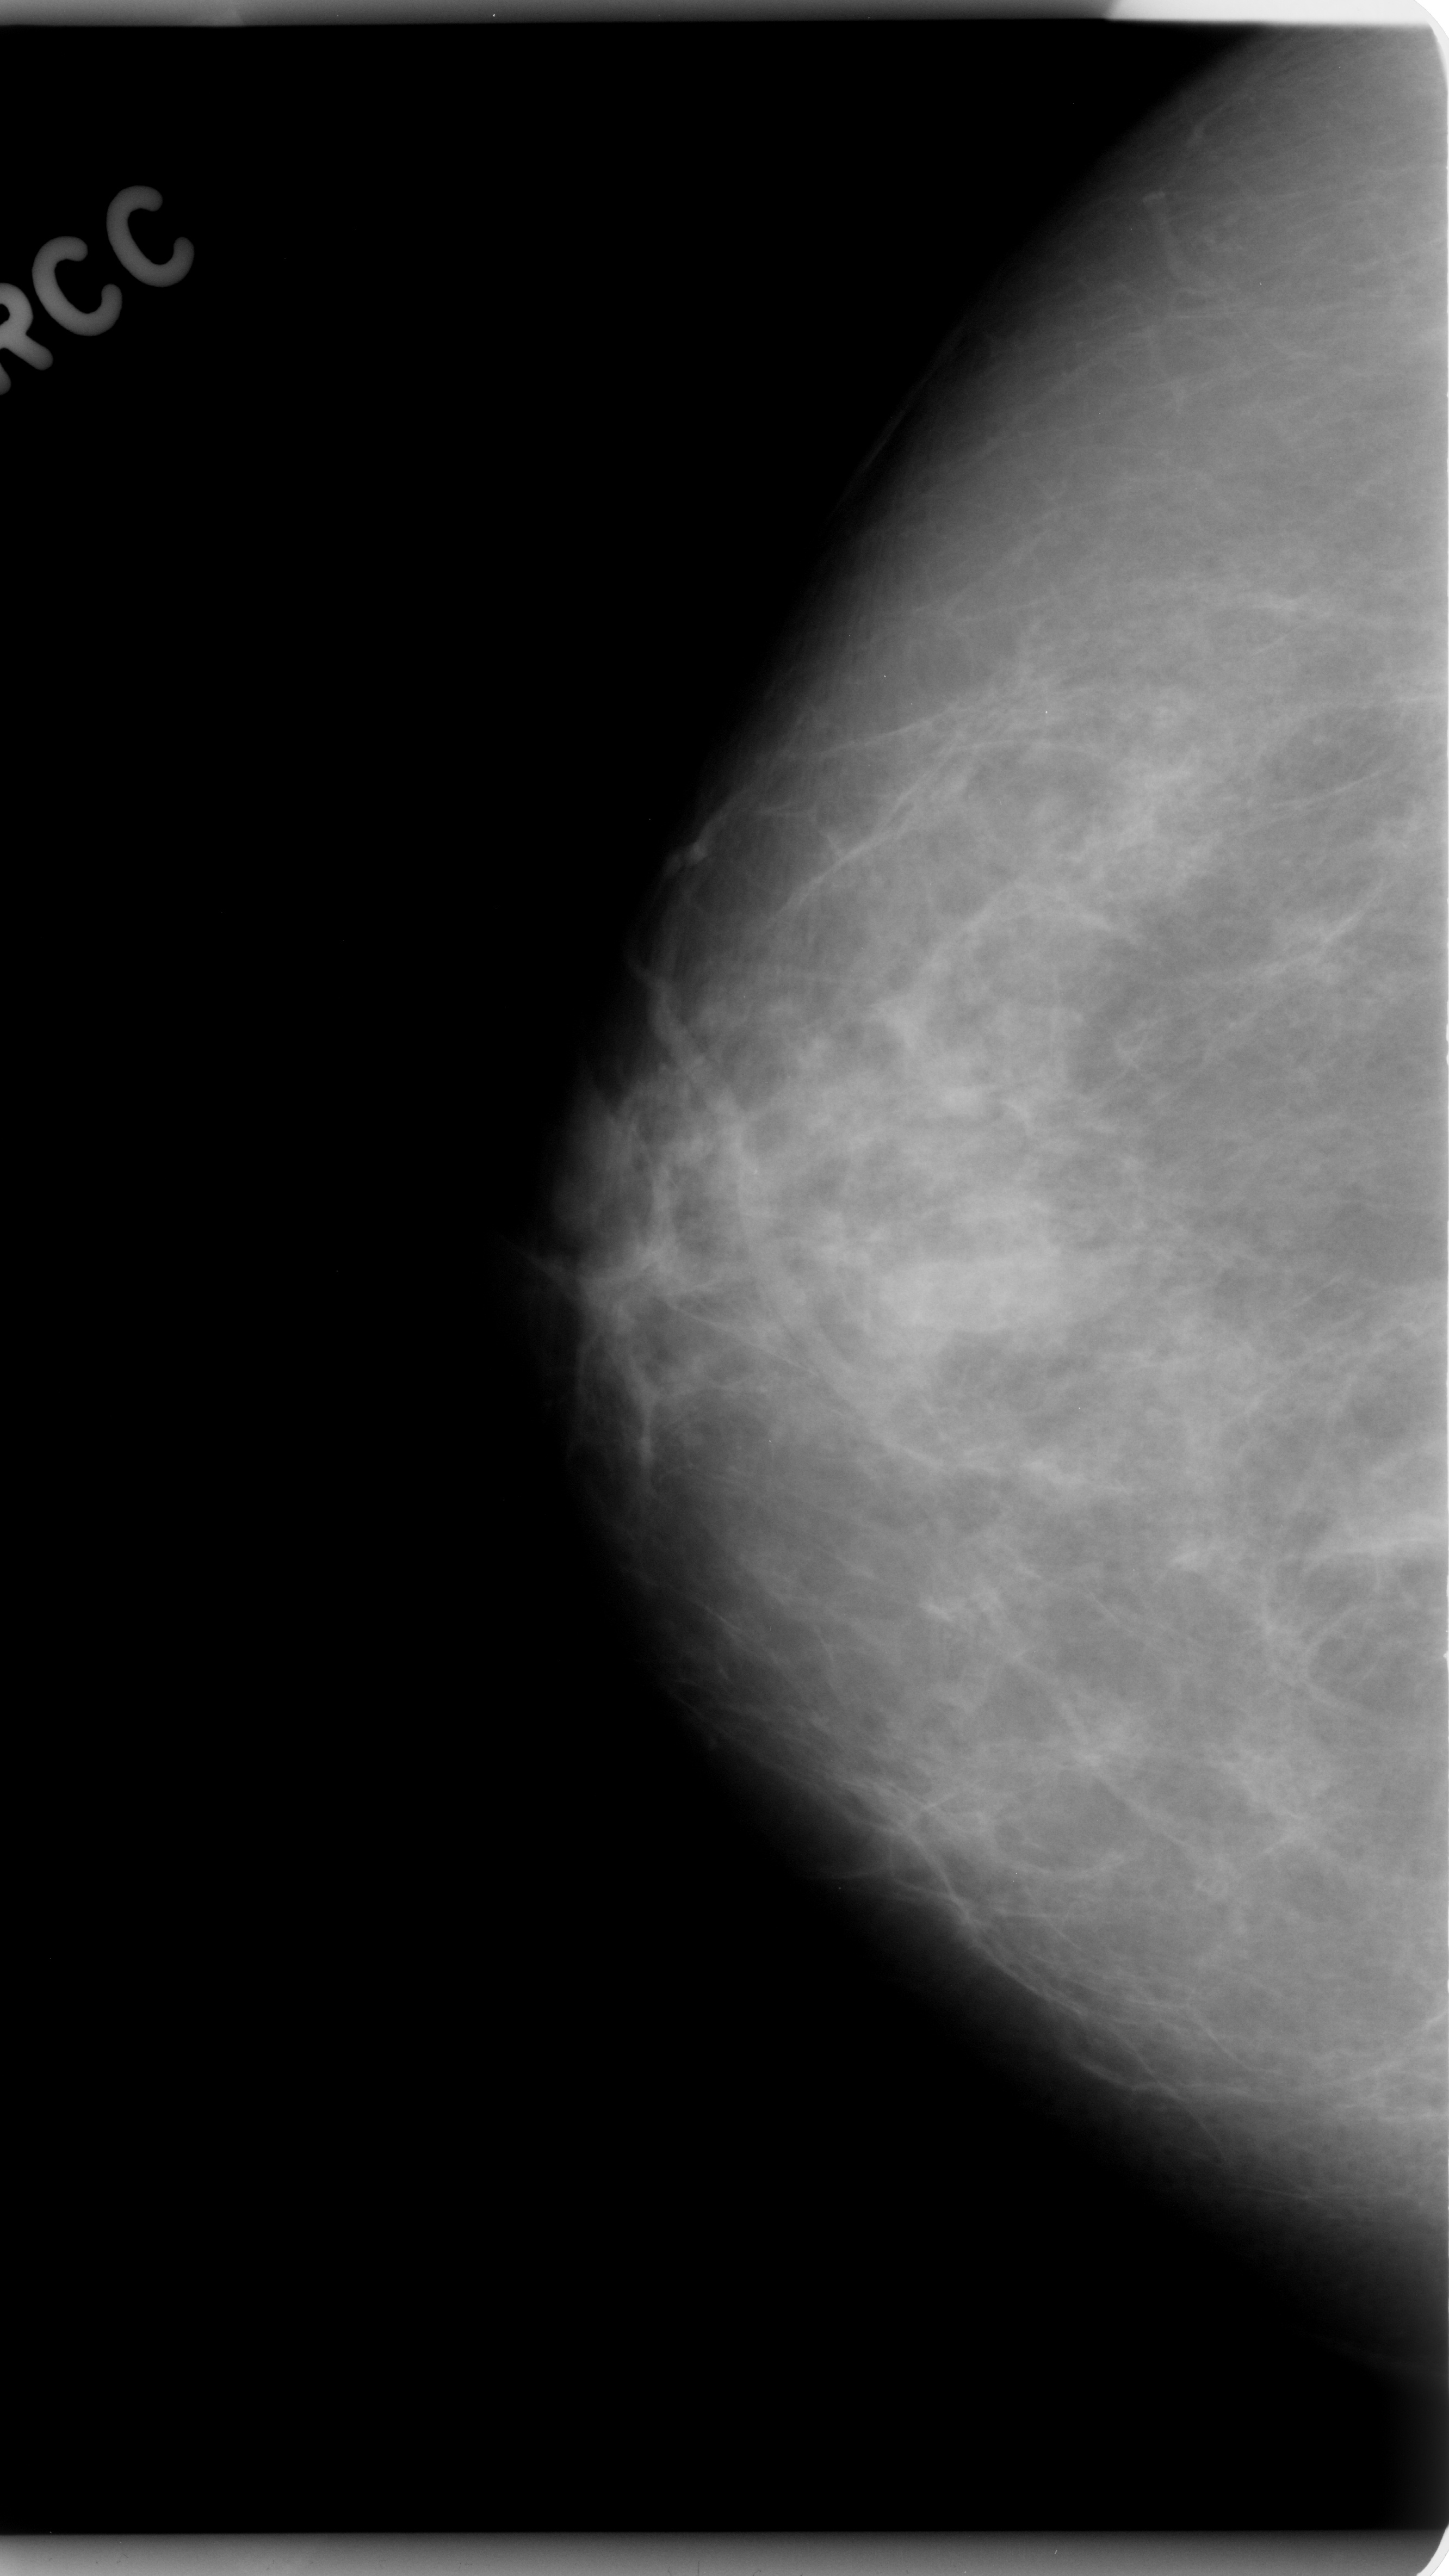

In [8]:
full

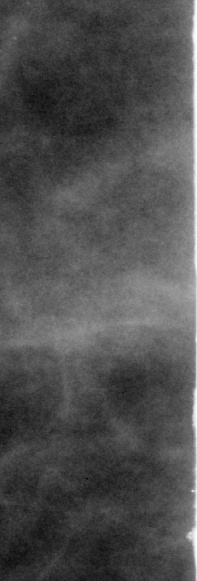

In [9]:
cropped

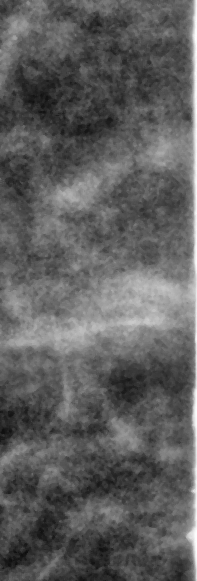

In [10]:
import cv2
# 2. Convert PIL Image to OpenCV/NumPy format
# Grayscale conversion is straightforward:
clip_limit=2
tile_grid_size=(8, 8)
img_np = np.array(cropped, dtype=np.uint8)

# 3. Create a CLAHE object
# 
denoised_np = cv2.medianBlur(img_np, 3)
clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

# 4. Apply CLAHE directly to the grayscale NumPy array
cl_img_np = clahe.apply(denoised_np)

# 5. Convert the final processed NumPy array back to a PIL Image object
processed_pil_img = Image.fromarray(cl_img_np)
processed_pil_img

## Prepare data as a hugging face dataset

Will transform the original data into a HF dataset containing: image, label, and extra features

In [11]:
CLASS_NAMES = [
    'BENIGN', 'MALIGNANT'
]

def get_label_from_filename(filename, data):
     current_pathology = data[data["cropped_image_file_path"] == filename]["pathology"].values[0]
     if current_pathology == "MALIGNANT": return 1
     if current_pathology == "BENIGN": return 0
     return -1

def get_mass_shape_from_filename(filename, data):
     current_mass_shape = data[data["cropped_image_file_path"] == filename]["mass_shape"].values[0]
     return current_mass_shape

def get_breast_from_filename(filename, data):
     current_breast = data[data["cropped_image_file_path"] == filename]["left_or_right_breast"].values[0]
     return current_breast

def get_mass_margins_from_filename(filename, data):
     current_margins = data[data["cropped_image_file_path"] == filename]["mass_margins"].values[0]
     return current_margins
    
mass_train_data_dict = {
    'image': [os.path.abspath(f) for f in mass_train_data["cropped_image_file_path"].values],
    'label': [get_label_from_filename(f, mass_train_data) for f in mass_train_data["cropped_image_file_path"].values],
    'mass_shape': [get_mass_shape_from_filename(f, mass_train_data) for f in mass_train_data["cropped_image_file_path"].values if f.startswith("/kaggle/input/")],
    'left_or_right': [get_breast_from_filename(f, mass_train_data) for f in mass_train_data["cropped_image_file_path"].values if f.startswith("/kaggle/input/")],
    'mass_margins': [get_mass_margins_from_filename(f, mass_train_data) for f in mass_train_data["cropped_image_file_path"].values if f.startswith("/kaggle/input/")]

}
mass_test_data_dict = {
    'image': [os.path.abspath(f) for f in mass_test_data["cropped_image_file_path"].values],
    'label': [get_label_from_filename(f, mass_test_data) for f in mass_test_data["cropped_image_file_path"].values],
    'mass_shape': [get_mass_shape_from_filename(f, mass_test_data) for f in mass_test_data["cropped_image_file_path"].values if f.startswith("/kaggle/input/")],
    'left_or_right': [get_breast_from_filename(f, mass_test_data) for f in mass_test_data["cropped_image_file_path"].values if f.startswith("/kaggle/input/")],
    'mass_margins': [get_mass_margins_from_filename(f, mass_test_data) for f in mass_test_data["cropped_image_file_path"].values if f.startswith("/kaggle/input/")]

}
features = Features({
    'image': HFImage(),
    'label': ClassLabel(names=CLASS_NAMES),
    'mass_shape': Value('string'),
    'left_or_right': Value('string'),
    'mass_margins': Value('string')
})
mass_train_dataset = Dataset.from_dict(mass_train_data_dict, features=features).cast_column("image", HFImage()).shuffle(seed=42)
mass_test_dataset = Dataset.from_dict(mass_test_data_dict, features=features).cast_column("image", HFImage()).shuffle(seed=42)

mass_train_dataset = mass_train_dataset.train_test_split(test_size=0.1, seed=420)

mass_train_dataset['validation'] = mass_train_dataset.pop('test')

print(mass_train_dataset)
print(mass_test_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'mass_shape', 'left_or_right', 'mass_margins'],
        num_rows: 1092
    })
    validation: Dataset({
        features: ['image', 'label', 'mass_shape', 'left_or_right', 'mass_margins'],
        num_rows: 122
    })
})
Dataset({
    features: ['image', 'label', 'mass_shape', 'left_or_right', 'mass_margins'],
    num_rows: 341
})


## Create a helper function to preprocess the image.

This function:
 - Denoise using Median Blur
 - Increase contrast by applying CLAHE
 - Resize image to 896x896 required by MedGemma
 - Transform into RGB 3 channel (required by the model)

In [12]:
def preprocess_image(image, clip_limit=2, tile_grid_size=(8, 8)):
    """
    Converts a grayscale PIL Image or a 1-channel NumPy array image to 
    a 3-channel RGB PIL Image by stacking the channels.
    """
    
    # Check if the input is a PIL Image
    if isinstance(image, Image.Image): 
        
        img_np = np.array(image, dtype=np.uint8)
        
        # 1. Denoise image with Median 3x3 filter 
        denoised_np = cv2.medianBlur(img_np, 3)

        # print("apply CLAHE")
        # 2. Apply CLAHE directly to the grayscale NumPy array
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        cl_img_np = clahe.apply(denoised_np)

        # print("\nresize")
        # 3. Convert the final processed NumPy array back to a PIL Image object
        processed_pil_img = Image.fromarray(cl_img_np)

        # 4. Reshape image to 896x896
        # Image.LANCZOS is used for high-quality downsampling/upsampling
        processed_pil_img = processed_pil_img.resize((896, 896), resample=Image.LANCZOS)
        
        # 5. Transform image to 3 channel RGB
        if processed_pil_img.mode in ('L', 'I', 'I;16'):
            return processed_pil_img.convert("RGB")
        # If it's already RGB/RGBA, just return it
        return processed_pil_img
    
    # Fallback for other formats
    return image

## Create prompts and format training and testing data into conversational messages

In [13]:
PROMPT = """Analyze this mammogram, the massification type and massification distribution and conclude whether the massification is benign or malignant based on its likelihood.
If you are not clear on the answer, and a further evaluation is needed, conclude the massification is malignant.
Your answer needs to be concise (max. 30 words) and must contain a Final assessment: (benign or malignant)
"""
# mass_classes = {
#     0: "MALIGNANT_PLEOMORPHIC",
#     1: "BENIGN_PLEOMORPHIC",
#     2: "MALIGNANT_Other",
#     3: "BENIGN_Other",
#     4: "BENIGN_AMORPHOUS",
#     5: "BENIGN_PUNCTATE",
#     6: "MALIGNANT_AMORPHOUS",
#     7: "MALIGNANT_PUNCTATE",
#     8: "BENIGN_FINE_LINEAR_BRANCHING",
#     9: "MALIGNANT_FINE_LINEAR_BRANCHING"
# }

mass_classes = {
    0: "BENIGN",
    1: "MALIGNANT"
}
#If you are not able to classify the mass with confidence and require further analysis, conclude it's class MALIGNANT. For patient's safety it's better to show a false positive than a false negative.

# Define the instruction prompt

#

PROMPT = """Analyze this cropped breast mammographic image containing a mass and classify it based on its likelihood. Is the mass benign or malignant?

Note: The most significant features that indicate whether a mass is benign or malignant are its shape and margins. Round-like masses are usually benign. An irregular shape suggests a greater likelihood of malignancy.

Your responses need to be less than 100 tokens and formatted in the following way:

    Analysis:
        - Location: (left or right) breast.
        - Mass shape observed:
        - Mass margins pattern:
        Based on these radiological features, the assessment is: (show 0 for benign or 1 for malignant.)
"""


PROMPT = """Analyze this cropped breast mammographic image containing a mass and classify it based on its likelihood. Is the mass benign or malignant?

Note: The most significant features that indicate whether a mass is benign or malignant are its shape and margins. The shape can be round, oval, lobular or irregular. The margins can be circumscribed, microlobulated, obscured (partially hidden by adjacent tissue), indistinct (ill-defined), or spiculated (characterized by lines radiating from the mass).
Round-like masses are usually benign. Masses with irregular shapes and indistinct or spiculated margins have a higher likelihood of malignancy.

Your responses need to be less than 100 tokens and formatted in the following way:

    Analysis:
        - Location: (left or right) breast.
        - Mass shape observed:
        - Mass margins pattern:
        Based on these radiological features, the assessment is: (show 0 for benign or 1 for malignant.)
"""

#PROMPT = "Analyze this cropped breast mammographic image. Give an estimation of the probability of the mass being malignant or benign."

def format_data(example):
    """Format examples into the chat-style messages MedGemma expects."""
    example["image"] = preprocess_image(example["image"])
    example["messages"] = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are an expert breast radiologist."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": PROMPT},
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": f"Analysis:\n\n"
                            f"- Location: {example['left_or_right']} breast\n"
                            f"- Mass shape observed: {example['mass_shape']}\n"
                            f"- Mass margins pattern: {example['mass_margins']}\n\n"
                            f"Based on these radiological features, the assessment is: **{example['label']}**"
                },
            ],
        },
    ]
    return example

def format_test_data(example: dict[str, any]) -> dict[str, any]:
    # example["prompt"] = PROMPT
    example["messages"] = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are an expert breast radiologist."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": PROMPT},
            ]
        }
    ]
    return example
# Apply formatting
formatted_mass_train_dataset = mass_train_dataset.map(format_data, batched=False, writer_batch_size=200).shuffle(seed=420)
formatted_mass_test_dataset = mass_test_dataset.map(format_test_data, batched=False).shuffle(seed=420)

print("✓ Data formatted with instruction prompts")

Map:   0%|          | 0/1092 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/341 [00:00<?, ? examples/s]

✓ Data formatted with instruction prompts


In [14]:
import pprint

# Prints the nicely formatted dictionary
# pprint.pprint(formatted_mass_train_dataset["train"][0])
pprint.pprint(formatted_mass_train_dataset["validation"][0])
# mass_train_dataset["train"]["label"]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=896x896 at 0x7F4B0CC510D0>,
 'label': 0,
 'left_or_right': 'LEFT',
 'mass_margins': 'OBSCURED',
 'mass_shape': 'OVAL',
 'messages': [{'content': [{'text': 'You are an expert breast radiologist.',
                            'type': 'text'}],
               'role': 'system'},
              {'content': [{'text': None, 'type': 'image'},
                           {'text': 'Analyze this cropped breast mammographic '
                                    'image containing a mass and classify it '
                                    'based on its likelihood. Is the mass '
                                    'benign or malignant?\n'
                                    '\n'
                                    'Note: The most significant features that '
                                    'indicate whether a mass is benign or '
                                    'malignant are its shape and margins. The '
                            

## Load the base MedGemma model

In [15]:
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

import gc
import torch

# Model ID (Ensure you have access)
model_id = "google/medgemma-4b-it"

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # NormalFloat 4 is recommended
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

torch.cuda.empty_cache()
gc.collect()

model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="eager",
)
processor = AutoProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

## Create helper functions to compute binary metrics, preprocess the prediction and predict in batches

In [16]:
from IPython.display import display, clear_output

# Helper functions to run evaluation
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall = evaluate.load("recall")
precision = evaluate.load("precision")

def compute_metrics(predictions, references):
    return {
        **accuracy_metric.compute(predictions=predictions, references=references),
        **f1_metric.compute(predictions=predictions, references=references, average="weighted"),
        **recall.compute(predictions=predictions, references=references, average="weighted"),
        **precision.compute(predictions=predictions, references=references, average="weighted")
    }

def postprocess_prediction(text):
    """Extract just the number from the model's text output."""
    digit_match = re.search(r'\b([0-9])\b', text.strip())
    
    predicted_digit = int(digit_match.group(1)) if digit_match else -1
    print(f"final prediction: {predicted_digit}")
    final_binary_prediction = 0 if str(predicted_digit) in ["0"] else 1
    
    print(f"final binary prediction {'benign' if final_binary_prediction == 0 else 'malignant'}")    
    return final_binary_prediction

def batch_predict(model, processor, prompts, images, labels, batch_size=1, max_new_tokens=500):
    """A function to run inference in batches."""
    predictions = []
    for i in range(0, len(prompts), batch_size):
               
        batch_texts = prompts[i:i + batch_size]
        label=labels[i:i + batch_size]

        # Clear previous output and display current image
        # clear_output(wait=True)
        
        batch_images = [img for img in images[i:i + batch_size]]
        

        # Logger: show progress
        print(f"\nProcessing batch {i//batch_size + 1} of {((len(prompts) - 1)//batch_size) + 1} "
              f"(indices {i} to {min(i+batch_size-1, len(prompts)-1)})")

        # display(batch_images[0])
        
        batch_texts = processor.apply_chat_template(
            batch_texts, add_generation_prompt=True, tokenize=False, return_tensors="pt"
        )
        
        inputs = processor(text=batch_texts, images=batch_images, padding=True, return_tensors="pt").to("cuda", torch.bfloat16)
        # print(inputs["pixel_values"])
        input_len = inputs["input_ids"].shape[-1]
        
        prompt_lengths = inputs["attention_mask"].sum(dim=1)

        with torch.inference_mode():
            outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
            outputs = outputs[0][input_len:]

        decoded = processor.decode(outputs, skip_special_tokens=True)
        print(decoded)
        print(f"Real value: {label}")
        predictions.append(postprocess_prediction(decoded))

    return predictions

## Prepare data for evaluation (test set, works for both base and fine tuned model)

[{'content': [{'text': 'You are an expert breast radiologist.', 'type': 'text'}], 'role': 'system'}, {'content': [{'text': None, 'type': 'image'}, {'text': 'Analyze this cropped breast mammographic image containing a mass and classify it based on its likelihood. Is the mass benign or malignant?\n\nNote: The most significant features that indicate whether a mass is benign or malignant are its shape and margins. The shape can be round, oval, lobular or irregular. The margins can be circumscribed, microlobulated, obscured (partially hidden by adjacent tissue), indistinct (ill-defined), or spiculated (characterized by lines radiating from the mass).\nRound-like masses are usually benign. Masses with irregular shapes and indistinct or spiculated margins have a higher likelihood of malignancy.\n\nYour responses need to be less than 100 tokens and formatted in the following way:\n\n    Analysis:\n        - Location: (left or right) breast.\n        - Mass shape observed:\n        - Mass margi

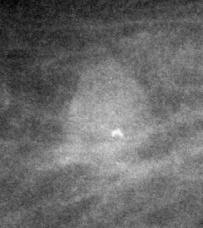

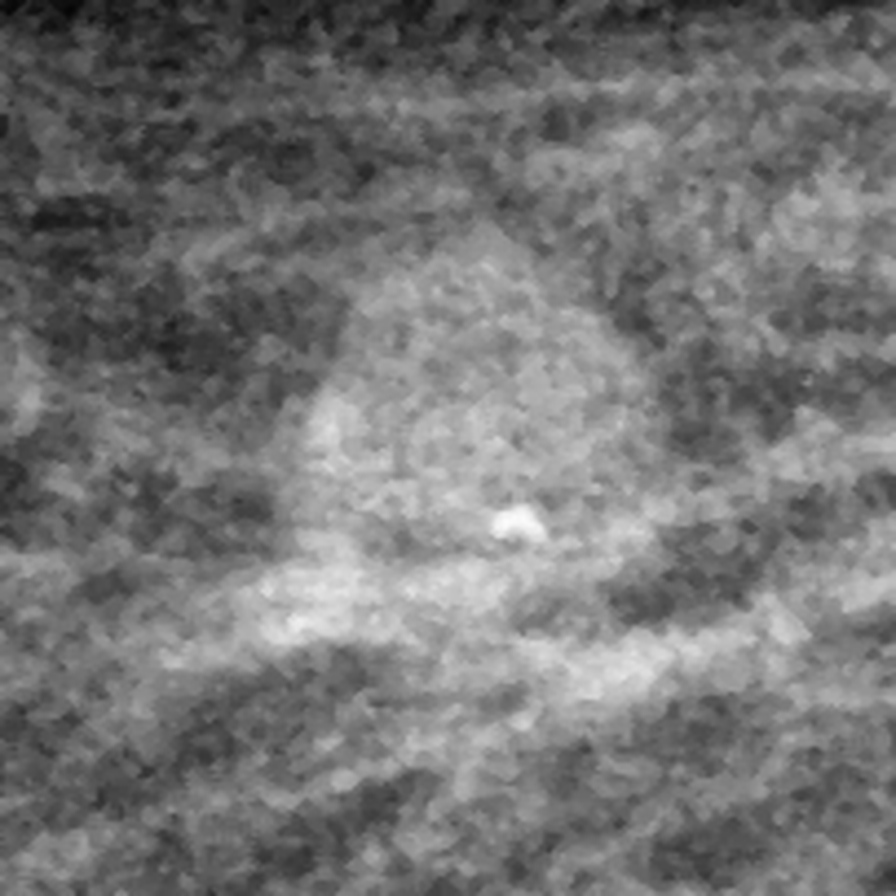



0: BENIGN




In [17]:
# Prepare data for evaluation
eval_prompts = [prompt for prompt in formatted_mass_test_dataset["messages"]]

# Apply the conversion to every image in your dataset list
eval_images = [preprocess_image(img) for img in formatted_mass_test_dataset["image"]]
eval_labels = formatted_mass_test_dataset["label"]



print(eval_prompts[0])
print("\n")
display(formatted_mass_test_dataset["image"][0])
display(eval_images[0])
print("\n")
print(f"{str(eval_labels[0])}: {mass_classes.get(eval_labels[0])}")
print("\n")


## Evaluate the base MedGemma model on test data

In [ ]:
# Run baseline evaluation
print("Running baseline evaluation...")
baseline_preds = batch_predict(model, processor, eval_prompts, eval_images, eval_labels)

In [ ]:
baseline_metrics = compute_metrics(baseline_preds, eval_labels)
print(f"\n{'BASELINE RESULTS':-^80}")
print(f"Accuracy: {baseline_metrics['accuracy']:.1%}")
print(f"F1 Score: {baseline_metrics['f1']:.3f}")
print(f"Recall: {baseline_metrics['recall']:.3f}")
print(f"Precision: {baseline_metrics['precision']:.3f}")
print("-" * 80)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(eval_labels, baseline_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "crest")
disp.ax_.set_title("Matriu de confusió rendiment baseline MedGemma per masses")
disp.ax_.set_xlabel("Valor predit")
disp.ax_.set_ylabel("Valor real")
plt.show()

In [ ]:
mass_train_data.mass_margins.value_counts()

## Prepare the fine tuning process: define LoRA and training configuration --> Train

In [ ]:
gc.collect()
torch.cuda.empty_cache()

from trl import SFTConfig, SFTTrainer
# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

# LoRA Configuration
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
)

# Custom data collator to handle images and text
def collate_fn(examples):
    texts, images = [], []
    for example in examples:
        images.append([example["image"]])
        texts.append(processor.apply_chat_template(example["messages"], add_generation_prompt=False, tokenize=False).strip())
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    image_token_id = processor.tokenizer.convert_tokens_to_ids(processor.tokenizer.special_tokens_map["boi_token"])
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100
    batch["labels"] = labels
    return batch


args = SFTConfig(
    output_dir="medgemma-mammography-masses-v2",            # Directory and Hub repository id to save the model to
    num_train_epochs=1,                       # Number of training epochs
    per_device_train_batch_size=1,                           # Batch size per device during training
    per_device_eval_batch_size=1,                            # Batch size per device during evaluation
    gradient_accumulation_steps=20,                           # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=0.2,                                        # Number of steps between logs
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",                                   # Evaluate every `eval_steps`
    eval_steps=0.2,                                           # Number of steps between evaluations
    learning_rate=5e-5,                             # Learning rate based on QLoRA paper
    bf16=True,                                               # Use bfloat16 precision
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.05,                                       # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
    push_to_hub=False,                                        # Push model to Hub
    report_to="none",                                 # Report metrics to tensorboard
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
    label_names=["labels"],                                  # Input keys that correspond to the labels
)

# Initialize and run the trainer
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=formatted_mass_train_dataset["train"],
    eval_dataset=formatted_mass_train_dataset["validation"].shuffle(seed=42),
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

print("Starting training...")
trainer.train()

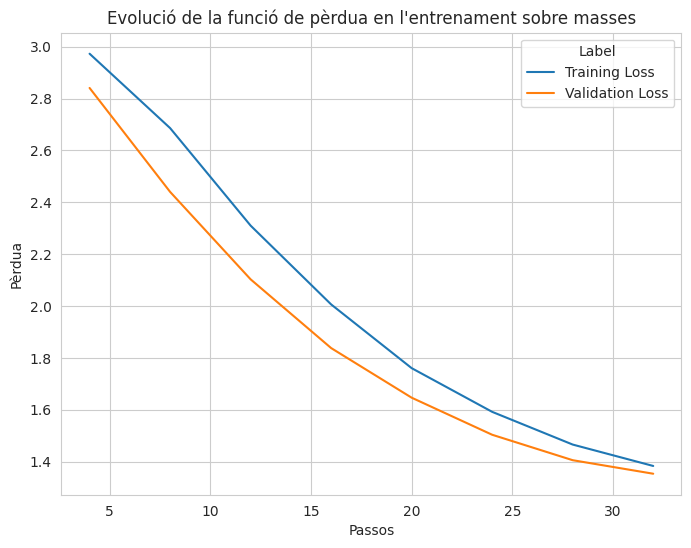

In [18]:
data = {
    "Step": [4, 8, 12, 16, 20, 24, 28, 32],
    "Training Loss": [
        2.9729, 2.6862, 2.3102, 2.0064,
        1.7607, 1.5922, 1.466100, 1.383600
    ],
    "Validation Loss": [
        2.8409, 2.4403, 2.1031, 1.8381,
        1.6468, 1.5039, 1.405814,1.353686
    ]
}

training_metrics = pd.DataFrame(data)
# Convert to long format
training_metrics = training_metrics.melt(
    id_vars="Step",
    value_vars=["Training Loss", "Validation Loss"],
    var_name="Label",
    value_name="Loss"
)

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
ax = sns.lineplot(data=training_metrics, x="Step", y="Loss", hue="Label")
ax.set(xlabel="Passos", ylabel='Pèrdua', title = "Evolució de la funció de pèrdua en l'entrenament sobre masses")
plt.show()

## Evaluate the fine-tuned model on test data

In [19]:
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel

import gc
import torch
# Clear memory and load the final model
del model
torch.cuda.empty_cache()
gc.collect()

MODEL_ID = "google/medgemma-4b-it"

# Load base model
base_model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Load LoRA adapters and merge them
finetuned_model = PeftModel.from_pretrained(base_model, "/kaggle/input/masses-fine-tuned/masses_fine_tuned")
finetuned_model = finetuned_model.merge_and_unload()

# Load processor from fine-tuned checkpoint
processor_finetuned = AutoProcessor.from_pretrained("/kaggle/input/masses-fine-tuned/masses_fine_tuned")
processor_finetuned.tokenizer.padding_side = "left" # for inference set left

# Configure for generation
finetuned_model.generation_config.do_sample = True
finetuned_model.generation_config.max_new_tokens = 256
finetuned_model.generation_config.pad_token_id = processor_finetuned.tokenizer.pad_token_id
finetuned_model.config.pad_token_id = processor_finetuned.tokenizer.pad_token_id

print("✓ Fine-tuned model loaded")

# Run evaluation
print("Running fine-tuned evaluation...")
finetuned_preds = batch_predict(finetuned_model, processor_finetuned, eval_prompts, eval_images, eval_labels)
finetuned_metrics = compute_metrics(finetuned_preds, eval_labels)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Fine-tuned model loaded
Running fine-tuned evaluation...

Processing batch 1 of 341 (indices 0 to 0)
Analysis:

- Location: Right breast
- Mass shape observed: Round
- Mass margins pattern: Circumscribed

Based on these radiological features, the assessment is: 0

Real value: [0]
final prediction: 0
final binary prediction benign

Processing batch 2 of 341 (indices 1 to 1)
Analysis:

- Location: Right breast
- Mass shape observed: Irregular
- Mass margins pattern: Spiculated

Based on these radiological features, the assessment is: 1

Real value: [1]
final prediction: 1
final binary prediction malignant

Processing batch 3 of 341 (indices 2 to 2)
Analysis:

- Location: Right breast
- Mass shape observed: Irregular
- Mass margins pattern: Spiculated

Based on these radiological features, the assessment is: 1

Real value: [1]
final prediction: 1
final binary prediction malignant

Processing batch 4 of 341 (indices 3 to 3)
Analysis:

- Location: Right breast
- Mass shape observed: Irreg

KeyboardInterrupt: 

In [ ]:
print(f"\n{'FINE-TUNED RESULTS':-^80}")
print(f"Accuracy: {finetuned_metrics['accuracy']:.1%}")
print(f"F1 Score: {finetuned_metrics['f1']:.3f}")
print(f"Recall: {finetuned_metrics['recall']:.3f}")
print(f"Precision: {finetuned_metrics['precision']:.3f}")
print("-" * 80)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style("whitegrid")

cm = confusion_matrix(eval_labels, finetuned_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap = "crest")
disp.ax_.grid(False)
disp.ax_.set_title("Matriu de confusió rendiment ajustat de MedGemma per masses")
disp.ax_.set_xlabel("Valor predit")
disp.ax_.set_ylabel("Valor real")
plt.show()